In [50]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from helper_functions import accuracy_fn
from timeit import default_timer as timer
from tqdm.auto import tqdm

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
train_data = MNIST(
    root='data',
    download=True,
    transform=ToTensor(),
    train=True,
    target_transform=None
)

test_data = MNIST(
    root='data',
    download=True,
    transform=ToTensor(),
    train=False,
)

100%|██████████| 9912422/9912422 [00:00<00:00, 40332384.82it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 72579804.57it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 21442962.24it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13482327.51it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [10]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

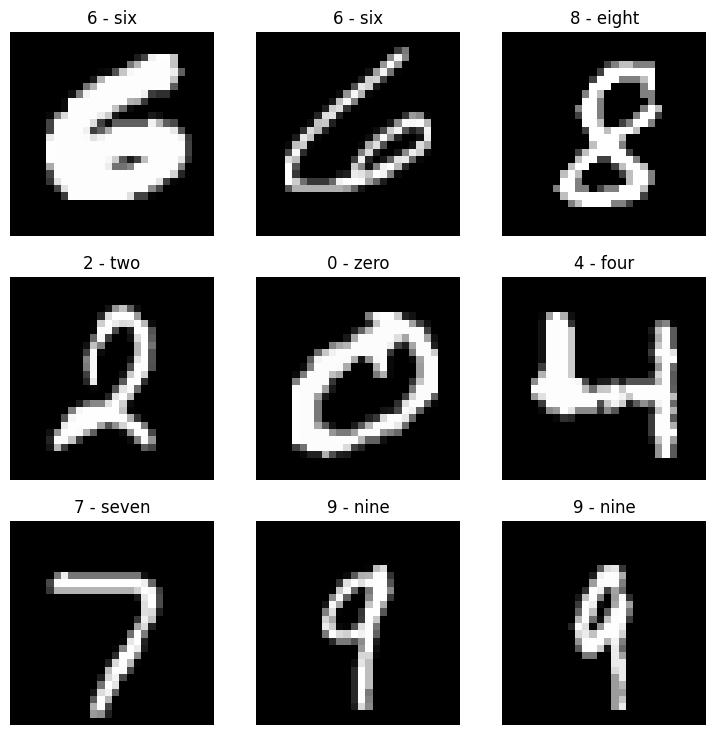

In [12]:
# Visualize the data
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols  = 3, 3
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap = 'gray')
    plt.title(class_names[label])
    plt.axis(False)

In [14]:
# Create the dataloader
train_loader = DataLoader(
    dataset=train_data,
    batch_size=32,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_data,
    batch_size=32,
    shuffle=False
)

In [20]:
len(train_loader), len(test_loader)

(1875, 313)

In [67]:
class CNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
            in_channels=input_dim,
            out_channels=hidden_dim,
            kernel_size=3,
            stride=1,
            padding=1),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            kernel_size=3,
            stride=1,
            padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            kernel_size=3,
            stride=1,
            padding=1),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            kernel_size=3,
            stride=1,
            padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_dim*7*7, out_features=output_dim)
        )
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [68]:
model = CNNModel(input_dim=1,hidden_dim=10, output_dim=len(class_names)).to(device)
model

CNNModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [69]:
# dummy forward pass
test_img_batch, test_label_batch = next(iter(train_loader))
test_img = test_img_batch[0,:,:,:].unsqueeze(dim = 0)
test_label = test_label_batch[0]
model_output = model(test_img)

In [70]:
model_output

tensor([[ 0.0281,  0.0369, -0.0412, -0.0367,  0.0076,  0.0032, -0.0039, -0.0171,
          0.0358,  0.0016]], grad_fn=<AddmmBackward0>)

In [71]:
class_names[torch.softmax(model_output, dim=1).argmax(dim=1)]

'1 - one'

In [73]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model.parameters(), lr=0.1)

In [74]:
def train_step(model, loader, loss_fn, accuracy_fn, device, epoch):
    train_loss, train_acc = 0, 0
    model.train()
    for X, y in tqdm(loader, desc=f'Training for epoch: {epoch}'):
        X = X.to(device)
        y = y.to(device)
        y_logits = model(X)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        loss = loss_fn(y_logits, y)
        acc = accuracy_fn(y, y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss
        train_acc += acc
    train_loss /= len(loader)
    train_acc /= len(loader)

    print(f'Train loss: {train_loss:.5f} | Train Accuracy: {train_acc:.2f}%')

def test_step(model, loader, loss_fn, device, epoch):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(loader, desc=f'Testing for epoch: {epoch}'):
            X = X.to(device)
            y = y.to(device)
            y_logits = model(X)
            y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
            loss = loss_fn(y_logits, y)
            acc = accuracy_fn(y, y_pred)
            test_loss += loss
            test_acc += acc
        test_loss /= len(loader)
        test_acc /= len(loader)

        print(f'Test loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%')

In [75]:
def print_train_time(start, end, device):
    time = end - start
    print(f'Train time on {device} is: {time}')
    return time

In [76]:
torch.manual_seed(42)
start_time = timer()
epochs = 3
for epoch in range(epochs):
    print(f'Epoch: {epoch}----')
    train_step(model, train_loader, loss_fn, accuracy_fn, device, epoch)
    test_step(model, test_loader, loss_fn, device, epoch)
end_time = timer()
model_train_time = print_train_time(start_time, end_time, device)

Epoch: 0----


Training for epoch: 0: 100%|██████████| 1875/1875 [00:29<00:00, 64.57it/s]


Train loss: 0.42731 | Train Accuracy: 85.42%


Testing for epoch: 0: 100%|██████████| 313/313 [00:00<00:00, 392.41it/s]


Test loss: 0.10872 | Test Accuracy: 96.75%
Epoch: 1----


Training for epoch: 1: 100%|██████████| 1875/1875 [00:28<00:00, 64.98it/s]


Train loss: 0.08781 | Train Accuracy: 97.31%


Testing for epoch: 1: 100%|██████████| 313/313 [00:00<00:00, 367.52it/s]


Test loss: 0.07522 | Test Accuracy: 97.54%
Epoch: 2----


Training for epoch: 2: 100%|██████████| 1875/1875 [00:28<00:00, 65.46it/s]


Train loss: 0.07172 | Train Accuracy: 97.80%


Testing for epoch: 2: 100%|██████████| 313/313 [00:00<00:00, 377.51it/s]

Test loss: 0.05404 | Test Accuracy: 98.16%
Train time on cpu is: 89.06611087499914


In [77]:
def eval_mode(model, loader, loss_fn, accuracy_fn, device):
    total_loss, total_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            y_logits = model(X)
            y_pred = torch.softmax(y_logits, dim = 1).argmax(dim=1)
            total_loss += loss_fn(y_logits, y)
            total_acc += accuracy_fn(y, y_pred)
        total_loss /= len(loader)
        total_acc /= len(loader)

    model_results = {
        'model_name': model.__class__.__name__,
        'model_loss': total_loss,
        'model_acc': total_acc
    }
    return model_results

In [78]:
model_results = eval_mode(model, test_loader, loss_fn, accuracy_fn, device)
model_results

{'model_name': 'CNNModel',
 'model_loss': tensor(0.0540),
 'model_acc': 98.1629392971246}

In [79]:
import random
torch.manual_seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
print(f'Img shape: {test_samples[0].shape}\nLabel: {test_labels[0]} ({class_names[test_labels[0]]})')

Img shape: torch.Size([1, 28, 28])
Label: 7 (7 - seven)


In [80]:
def make_predictions(model, data, device=device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim = 0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

In [82]:
pred_probs = make_predictions(model, test_samples)
pred_probs[:2]

tensor([[1.0250e-04, 2.8612e-04, 1.1229e-04, 1.9134e-04, 4.8884e-04, 1.1648e-05,
         1.3874e-07, 7.8009e-01, 2.3954e-03, 2.1632e-01],
        [5.9988e-01, 7.6106e-03, 9.7711e-03, 2.5900e-04, 8.2391e-03, 8.5414e-04,
         2.9700e-01, 5.7807e-06, 7.5715e-02, 6.6136e-04]])

In [83]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([7, 0, 1, 2, 3, 0, 4, 6, 7])

In [84]:
test_labels, pred_classes

([7, 0, 1, 2, 3, 0, 4, 6, 7], tensor([7, 0, 1, 2, 3, 0, 4, 6, 7]))

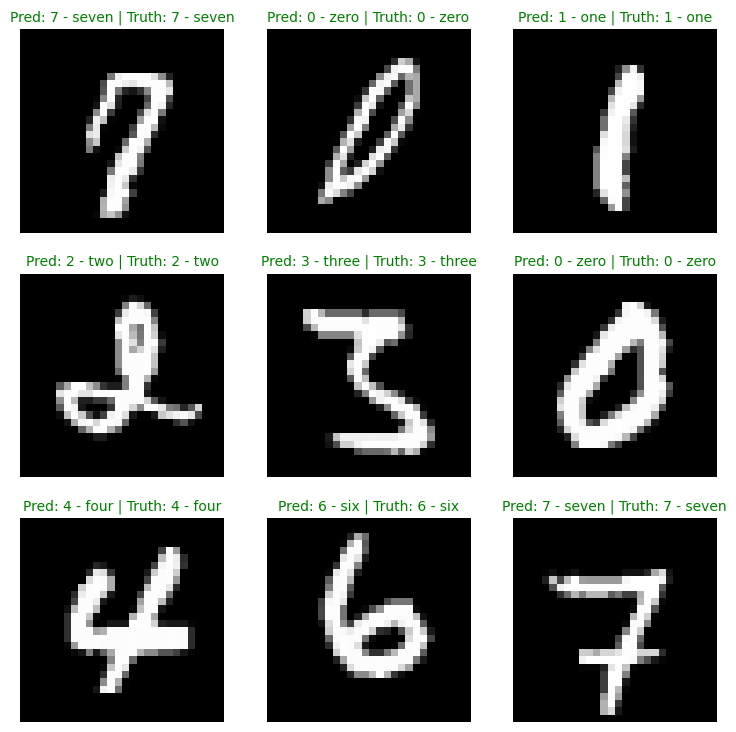

In [85]:
# Plot predictions
plt.figure(figsize=(9,9))
nrows, ncols = 3, 3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap='gray')
    predlabel = class_names[pred_classes[i]]
    truthlabel = class_names[test_labels[i]]
    titletext = f'Pred: {predlabel} | Truth: {truthlabel}'
    if predlabel == truthlabel:
        plt.title(titletext, fontsize=10, c='g')
    else:
        plt.title(titletext, fontsize=10, c='r')
    plt.axis(False)